In [1]:
root="../.."

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

from joblib import dump, load

# Load data

In [2]:
abun=pd.read_csv("%s/data/metagenomics/Specie_abundance_filtered_90percent_maaslined.csv"%(root), index_col=0)
kegg=pd.read_csv("%s/data/metagenomics/KEGG_downsampled_90percent_maaslined.csv"%(root), index_col=0)
immune=pd.read_csv("%s/data/immuno/immune_percentage.csv"%(root), index_col=0)
bioc=pd.read_csv("%s/data/metabolomics/Metabolomics_masslined.csv"%(root), index_col=0)
samples = list(set(abun.columns) & set(immune.columns) & set(bioc.columns))

In [3]:
subgroup_list = load("%s/codes/correlation/Subgroup_sample_list.joblib"%(root))
for key, value in subgroup_list.items():
    new_value = [item for item in value if item in samples]
    subgroup_list[key] = new_value

In [4]:
module_decode = pd.read_csv("%s/output/correlation/table/Module_decode.csv"%(root), index_col=0)
module_engene = pd.read_csv("%s/output/correlation/table/Module_Eigengene_Full.csv"%(root), index_col=0)
module_member = dict()
for i in module_engene.columns:
    omics, color = i.split(".")
    module_imp = pd.read_csv("%s/output/correlation/table/%s_feature_importance.csv"%(root, omics), index_col=0)
    module_imp = module_imp.loc[:,'%s.mergedColors'%(omics)]
    member_i = module_imp.index[module_imp == color]
    module_member[i] = member_i
module_member_series = pd.Series({item: '{}.{}'.format(key,module_decode.loc[key,'decode']) for key, value_list in module_member.items() for item in value_list})

In [5]:
microbiome_member = [item for key, value in module_member.items() if 'Specie' in key or 'KEGG' in key for item in value]
blood_member = [item for key, value in module_member.items() if 'Metabolome' in key or 'Immune' in key for item in value]

In [6]:
microbiome = pd.concat([abun, kegg], axis=0)
blood = pd.concat([immune, bioc], axis=0)
microbiome = microbiome.loc[microbiome_member,samples]
blood = blood.loc[blood_member,samples]
mat = pd.concat([microbiome, blood],axis=0).T

---
# Aggregate the results

In [7]:
healthy_list = ['Young_Healthy', 'Elder_Healthy', 'Female_Healthy', 'Male_Healthy','NormalWeight_Healthy', 'OverWeight_Healthy']
patient_list = ['Young_Patient', 'Elder_Patient', 'Female_Patient', 'Male_Patient','NormalWeight_Patient', 'OverWeight_Patient']
group_list = healthy_list + patient_list

In [8]:
def spearman_p_adjust(mat):
    corr_mat = mat.corr(method='spearman')
    corr_mat = corr_mat.loc[microbiome_member, blood_member]
    corr_mat_p = pd.DataFrame(1, index=microbiome_member, columns=blood_member)
    for microbe in microbiome_member:
        for blood in blood_member:
            _, p = spearmanr(mat.loc[:,microbe], mat.loc[:,blood])
            corr_mat_p.loc[microbe, blood] = p
        p_adjust = corr_mat_p.loc[microbe, :]
        p_adjust = np.nan_to_num(p_adjust, nan=1.0)
        p_adjust = multipletests(p_adjust,alpha=0.05, method='fdr_bh')[1]
        corr_mat_p.loc[microbe, :] = p_adjust
    corr_mat[corr_mat_p > 0.05] = 0
    return(corr_mat)

In [9]:
def stack_mat(corr_mat):
    result_module_module = corr_mat.stack() 
    result_module_module.index = ['{}-{}'.format(idx[0], idx[1]) for idx in result_module_module.index]
    result_1 = corr_mat.groupby([i.split(".")[0] for i in corr_mat.columns], axis=1).sum().stack()
    result_1.index = ['{}-{}'.format(idx[0], idx[1]) for idx in result_1.index]
    result_2 = corr_mat.groupby([i.split(".")[0] for i in corr_mat.index], axis=0).sum().stack() 
    result_2.index = ['{}-{}'.format(idx[1], idx[0]) for idx in result_2.index]
    result_3 = corr_mat.sum(axis=0)
    result_3.index = ['{}-{}'.format(idx, 'Microbiome') for idx in result_3.index]
    result_4 = corr_mat.sum(axis=1)
    result_4.index = ['{}-{}'.format(idx, 'Blood') for idx in result_4.index]
    result_module_omics = pd.concat([result_1,result_2,result_3,result_4])
    result_oo_1 = corr_mat.groupby([i.split(".")[0] for i in corr_mat.columns], 
                                   axis=1).sum().groupby([i.split(".")[0] for i in corr_mat.index], axis=0).sum()
    result_oo_1_stack = result_oo_1.stack()
    result_oo_1_stack.index = ['{}-{}'.format(idx[0], idx[1]) for idx in result_oo_1_stack.index]
    result_oo_2 = result_oo_1.sum(axis=0)
    result_oo_2.index = ['{}-{}'.format(idx, 'Microbiome') for idx in result_oo_2.index]
    result_oo_3 = result_oo_1.sum(axis=1)
    result_oo_3.index = ['{}-{}'.format(idx, 'Blood') for idx in result_oo_3.index]
    result_oo_4 = pd.Series(result_oo_3.sum(), index=['Microbiome-Blood'])
    result_omics_omics = pd.concat([result_oo_1_stack,result_oo_2,result_oo_3,result_oo_4])
    
    result = pd.concat([result_module_module, result_module_omics, result_omics_omics])
    return(result)

In [10]:
def group_calculate_pos_neg(group_name):
    corr_mat = spearman_p_adjust(mat.loc[subgroup_list[group_name],:])
    pos_mat = corr_mat.where(corr_mat > 0.35, 0).where(corr_mat <= 0.35, 1)
    neg_mat = corr_mat.where(corr_mat < -0.35, 0).where(corr_mat >= -0.35, 1)
    pos_by_module = pos_mat.groupby(module_member_series[microbiome_member]).sum().groupby(module_member_series[blood_member], axis=1).sum()
    neg_by_module = neg_mat.groupby(module_member_series[microbiome_member]).sum().groupby(module_member_series[blood_member], axis=1).sum()
    pos_result = stack_mat(pos_by_module)
    neg_result = stack_mat(neg_by_module)
    return(corr_mat, pos_result, neg_result)

In [11]:
corr_mat_dict = dict()
pos_mat = pd.DataFrame(None, columns=group_list)
neg_mat = pd.DataFrame(None, columns=group_list)
for i in group_list:
    corr_mat, pos_result, neg_result = group_calculate_pos_neg(i)
    corr_mat_dict[i] = corr_mat
    if pos_mat.empty: pos_mat = pos_mat.reindex(index= pos_result.index)
    if neg_mat.empty: neg_mat = neg_mat.reindex(index= neg_result.index)
    pos_mat.loc[pos_result.index,i] = pos_result
    neg_mat.loc[neg_result.index,i] = neg_result
dump({'corr_mat_dict': corr_mat_dict, 'pos_mat': pos_mat, 'neg_mat': neg_mat}, 
     '%s/codes/correlation/correlation_adjusted_result.joblib'%(root))

/tmp/ipykernel_143777/3033236314.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  _, p = spearmanr(mat.loc[:,microbe], mat.loc[:,blood])
/tmp/ipykernel_143777/3033236314.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  _, p = spearmanr(mat.loc[:,microbe], mat.loc[:,blood])
/tmp/ipykernel_143777/3033236314.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  _, p = spearmanr(mat.loc[:,microbe], mat.loc[:,blood])
/tmp/ipykernel_143777/3033236314.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  _, p = spearmanr(mat.loc[:,microbe], mat.loc[:,blood])
/tmp/ipykernel_143777/3033236314.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  _, p = spearmanr(mat.loc[:,microbe], mat.loc[:,blood])
/tmp/ipykernel_143777/3033236314.py:7: ConstantInp

['../../codes/correlation/correlation_adjusted_result.joblib']

---
# Plot the significant groups

In [12]:
def find_module_members(module_pair):
    part_1, part_2 = i.split("-")
    part_1 = part_1.split(".")[:2]
    part_1 = ".".join(part_1)
    part_1_members = module_member[part_1]
    if part_2 =='Microbiome':
        part_2_members = microbiome_member
    elif part_2 =='Blood':
        part_2_members = blood_member
    else:
        part_2_members = [item for key, value in module_member.items() if part_2 in key for item in value]
    if part_1_members[0] in microbiome_member:
        return(part_1_members, part_2_members)
    else:
        return(part_2_members, part_1_members)

In [13]:
correlation_adjusted_result = load('%s/codes/correlation/correlation_adjusted_result.joblib'%(root))
pos_mat = correlation_adjusted_result['pos_mat']
neg_mat = correlation_adjusted_result['neg_mat']
corr_mat_dict = correlation_adjusted_result['corr_mat_dict']

In [14]:
module_name = ['KEGG.purple.Pyruvate','Metabolome.yellow.Steroids','Immune.pink.CD8 MAIT',
               'KEGG.brown.Amino Acid','KEGG.green.Antibiotics','KEGG.red.Benzoate Degradate','Immune.blue.Th17',
               'Specie.blue.Blautia Flavonifractor',
               'Metabolome.turquoise.Phospholipids','Immune.brown.INFg+ Memory CD4']
module_pair = [j for i in module_name for j in pos_mat.index if (i in j) and (j.count(".") < 4)]
module_pair = [i for i in module_pair if ('Blood' in i) or ('Microbiome' in i)]

In [15]:
bar_pos = pos_mat.loc[module_pair,group_list]
bar_neg = neg_mat.loc[module_pair,group_list]

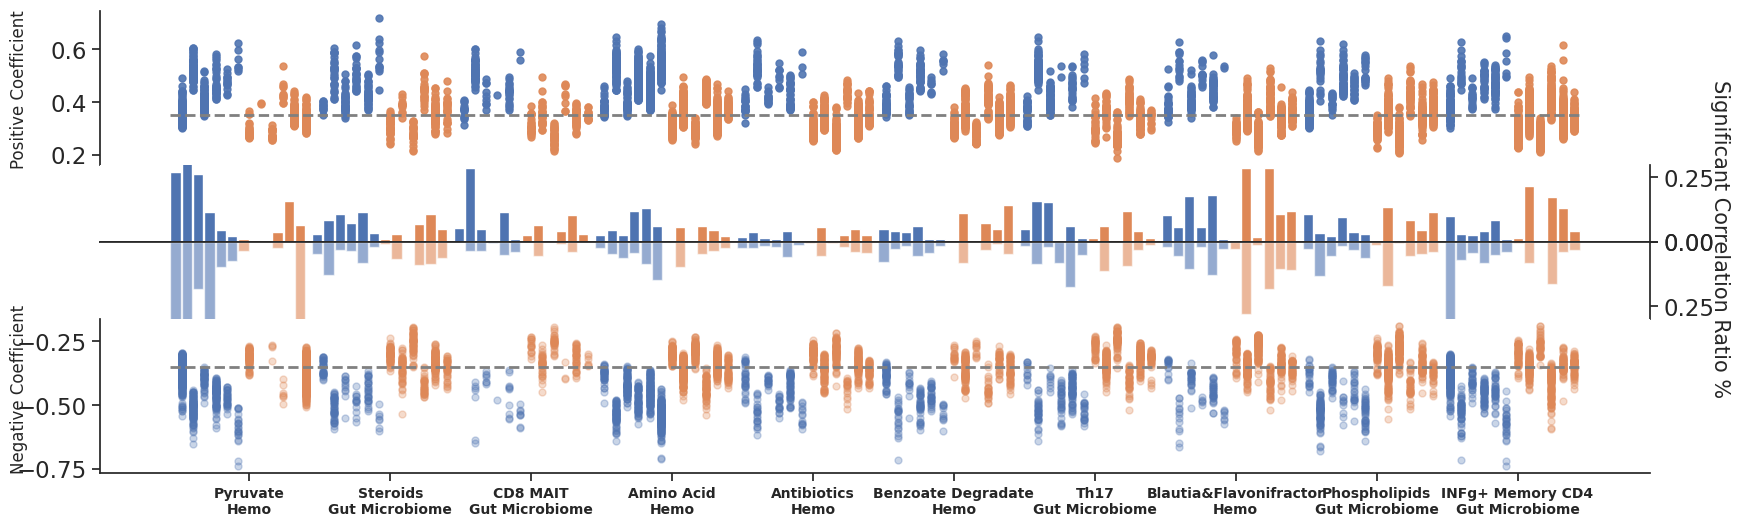

In [16]:
sns.set(style='ticks', font_scale=1.5, font='sans-serif')
fig = plt.figure(figsize=(20,6))

heights = [4,2,2,4]
spec = fig.add_gridspec(ncols=1, nrows=4, height_ratios=heights, hspace=0)
positive_stacked_dot_ax = fig.add_subplot(spec[0, 0])
positive_bar_ax = fig.add_subplot(spec[1, 0])
negative_bar_ax = fig.add_subplot(spec[2, 0])
negative_stacked_dot_ax = fig.add_subplot(spec[3, 0])

#####
x_loc = 0
for i in module_pair:
    for j in group_list:
        color = '#4f74b1' if j in healthy_list else '#de8857'
        index_list, column_list = find_module_members(i)
        
        # Bar plots
        positive_bar_ax.bar(x_loc, bar_pos.loc[i, j]/len(index_list)/len(column_list) * 100, 
                            color=color, width=0.9, edgecolor='white')
        negative_bar_ax.bar(x_loc, bar_neg.loc[i, j]/len(index_list)/len(column_list) * 100, 
                            color=color, width=0.9, edgecolor='white',alpha=0.6)
        
        # Scatter plots
        corr_max_j = corr_mat_dict[j].loc[index_list, column_list].to_numpy().flatten()
        positive_stacked_dot_ax.scatter([x_loc] * len(corr_max_j[corr_max_j > 0]), 
                                        corr_max_j[corr_max_j > 0], s=25, color=color,alpha=0.9)
        negative_stacked_dot_ax.scatter([x_loc] * len(corr_max_j[corr_max_j < 0]), 
                                        corr_max_j[corr_max_j < 0], s=25, color=color,alpha=0.3)
        
        x_loc += 1
    x_loc+=0.5

#### Adjust ticks
# bar
for ax in [positive_bar_ax, negative_bar_ax]:
    ax.yaxis.tick_right()
    ax.set_ylim([0,0.3])
    ax.set_xticks([])
    
positive_bar_ax.spines['left'].set_visible(False)
positive_bar_ax.spines['top'].set_visible(False)
negative_bar_ax.spines['left'].set_visible(False)
negative_bar_ax.spines['bottom'].set_visible(False)
negative_bar_ax.invert_yaxis()

# stacked dot
for ax in [positive_stacked_dot_ax, negative_stacked_dot_ax]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

positive_stacked_dot_ax.hlines(0.35, -1, x_loc-1, linestyles = 'dashed', lw = 2, colors = 'grey')
positive_stacked_dot_ax.spines['bottom'].set_visible(False)
positive_stacked_dot_ax.set_xticks([])

negative_stacked_dot_ax.hlines(-0.35, -1, x_loc-1, linestyles = 'dashed', lw = 2, colors = 'grey')
ticks_start = len(group_list) / 2
ticks_location = [ticks_start + (x_loc+len(module_pair)*2.5)/len(group_list)*i for i in range(len(module_pair))]
module_name = [i.split(".")[::-1][0].replace('Blood','Hemo').replace('Microbiome','Gut Microbiome').replace('Blautia ', 'Blautia&').replace('-','\n') for i in module_pair]
negative_stacked_dot_ax.set_xticks(ticks_location)
negative_stacked_dot_ax.set_xticklabels(module_name, fontsize=10, fontweight='bold')

fig.text(0.08, 0.25, 'Negative Coefficient', va='center', fontsize=12, rotation=90)
fig.text(0.08, 0.75, 'Positive Coefficient', va='center', fontsize=12, rotation=90)
fig.text(0.93, 0.5, 'Significant Correlation Ratio %', va='center', fontsize=15, rotation=270)

plt.savefig("%s/output/correlation/figure/Correlation_Count_by_Member.pdf" %(root), 
            dpi=1000, bbox_inches='tight',transparent=True)